In [1]:
import operator
import random
import requests
import time
import csv
import os
import pandas as pd
import seaborn as sns
import numpy as np
import networkx as nx
import scipy
from scipy import stats
from ast import literal_eval
from matplotlib import pyplot as plt
from statsmodels.stats import diagnostic
from datetime import datetime
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split

# Data standard scaler
from sklearn.preprocessing import StandardScaler

# Random train-test split
from sklearn.model_selection import train_test_split

# Metrics and model selection
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, auc, roc_curve, precision_recall_curve
from sklearn.model_selection import cross_val_predict

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from scipy.stats import ttest_ind

from networkx.algorithms import bipartite

#To visualize on of the RandomForest decision trees
#from sklearn import tree

#colors used when comparing genders
PURPLE = 'purple'
ORANGE = '#ffb82c'

#colors used when generic comparisons
BLUE = '#0173b2'
RED = '#d55e00'

#print(sns.color_palette("colorblind").as_hex())
#sns.color_palette("colorblind")

In [2]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

# 1. Load the data
<a class="anchor" id="load"></a>

In [3]:
DATA_PATH = './data'
MOVIE_PATH = os.path.join(DATA_PATH, 'american_movies_filtered.tsv')
CHAR_PATH = os.path.join(DATA_PATH, 'characters_filtered.tsv')
THE_NUMBERS_PATH = os.path.join(DATA_PATH, 'the_numbers_lifetime_cumulative.tsv')
THE_NUMBERS_PATH_YEARLY = os.path.join(DATA_PATH, 'the_numbers_yearly_score.tsv')

### 1.1 Characters data
<a class="anchor" id="load_characters"></a>

In [4]:
df_chars=pd.read_csv(CHAR_PATH, sep="\t")
df_chars['m_release_date']=pd.to_datetime(df_chars['m_release_date'], errors = 'coerce')
df_chars.head(2)

,wikipedia_m_ID,m_release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,m_name,m_genre_PCA
0,975900,2001-08-24,Akooshay,1958-08-26,F,1.62,NaN,Wanda De Jesus,42.0,Ghosts of Mars,"Thriller, Crime Thriller, Action, Mystery"
1,975900,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.78,NaN,Natasha Henstridge,27.0,Ghosts of Mars,"Thriller, Crime Thriller, Action, Mystery"


### 1.2 Movies data
<a class="anchor" id="load_movies"></a>

In [5]:
df_movies=pd.read_csv(MOVIE_PATH, sep='\t')
df_movies['m_release_date']=pd.to_datetime(df_movies['m_release_date'], errors = 'coerce')
df_movies.head(2)

,wikipedia_m_ID,m_name_x,m_release_date,m_BO_revenue,m_runtime,m_languages,m_countries,m_genres,m_genre_PCA,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,m_name_y
0,975900,Ghosts of Mars,2001-08-24,14010832.0,98.0,['English Language'],United States of America,"['Thriller', 'Science Fiction', 'Horror', 'Adv...","Thriller, Crime Thriller, Action, Mystery",Akooshay,1958-08-26,F,1.62,NaN,Wanda De Jesus,42.0,Ghosts of Mars
1,3196793,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,['English Language'],United States of America,"['Mystery', 'Biographical film', 'Drama', 'Cri...","Mystery, Horror, Children's/Family, Drama",Reporter,1956-12-19,F,NaN,NaN,Alice Barrett,43.0,Getting Away with Murder: The JonBenét Ramsey ...


### 1.4 The numbers data yearly

In [6]:
df_numbers=pd.read_csv(THE_NUMBERS_PATH_YEARLY, sep='\t').set_index('actor_name')
df_numbers.reset_index(inplace=True)
df_numbers.head(2)

,actor_name,1980,1981,1982,1983,1984,1985,1986,1987,1988,...,2005,2006,2007,2008,2009,2010,2011,2012,min_year,min_year_score
0,Jane Fonda,2475.0,3910.5,2161.5,1509.75,1163.25,947.100000,2689.071429,1636.232143,1239.125000,...,3026.612308,1649.474359,1183.301948,945.483026,799.422414,699.538710,626.261864,569.781250,1980,2475.0
1,Clint Eastwood,5394.0,2697.0,4636.0,5963.50,9801.80,8879.333333,8991.838095,5988.366667,7511.228571,...,5771.129002,4778.685758,4185.983006,8665.604883,5901.331475,4831.223973,4212.135890,4683.724922,1980,5394.0


# 2.1 Dataset preparation

In [7]:
df_chars_merged = df_chars.merge(df_numbers, on='actor_name', how='left').copy()
numbers_columns = df_numbers.columns[1:]
df_chars_merged[numbers_columns] = df_chars_merged[numbers_columns].fillna(0)
df_chars_merged['min_year'] = df_chars_merged['min_year'].astype('int')
df_chars_merged.head()

,wikipedia_m_ID,m_release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,m_name,...,2005,2006,2007,2008,2009,2010,2011,2012,min_year,min_year_score
0,975900,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,Ghosts of Mars,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.0
1,975900,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,NaN,Natasha Henstridge,27.0,Ghosts of Mars,...,76.000000,65.142857,57.000000,50.666667,45.600000,41.454545,38.000000,35.076923,2000,456.0
2,975900,2001-08-24,Desolation Williams,1969-06-15,M,1.727,African Americans,Ice Cube,32.0,Ghosts of Mars,...,3255.369913,1990.897222,2641.254319,2432.196392,1729.285333,1391.918606,1179.534513,1029.515124,1991,78.0
3,975900,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,Ghosts of Mars,...,715.333333,426.228571,311.050000,930.650794,546.942857,2009.549784,1152.650000,2576.304895,2000,38.0
4,975900,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea Duvall,23.0,Ghosts of Mars,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.0


In [8]:
df_chars_merged['is_revealed'] = df_chars_merged.apply(lambda row: row['min_year'] == row['m_release_date'].year, axis=1).astype(int)
df_chars_merged['already_revealed'] = df_chars_merged.apply(lambda row: row['min_year'] < row['m_release_date'].year and row['min_year']!=0.0, axis=1).astype(int)
df_chars_merged.head()

,wikipedia_m_ID,m_release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,m_name,...,2007,2008,2009,2010,2011,2012,min_year,min_year_score,is_revealed,already_revealed
0,975900,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,Ghosts of Mars,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.0,0,0
1,975900,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,NaN,Natasha Henstridge,27.0,Ghosts of Mars,...,57.000000,50.666667,45.600000,41.454545,38.000000,35.076923,2000,456.0,0,1
2,975900,2001-08-24,Desolation Williams,1969-06-15,M,1.727,African Americans,Ice Cube,32.0,Ghosts of Mars,...,2641.254319,2432.196392,1729.285333,1391.918606,1179.534513,1029.515124,1991,78.0,0,1
3,975900,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,Ghosts of Mars,...,311.050000,930.650794,546.942857,2009.549784,1152.650000,2576.304895,2000,38.0,0,1
4,975900,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea Duvall,23.0,Ghosts of Mars,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.0,0,0


# 2.2 Movies that have a revelation

In [14]:
df_movie_revelation = df_chars_merged.groupby(['wikipedia_m_ID', 'm_release_date']).agg({'is_revealed': 'sum', 'already_revealed':'sum'}).copy().reset_index()

df_movie_revelation.rename({'is_revealed' : 'has_revelation', 'already_revealed' : 'has_famous_actors'}, axis=1, inplace=True)
df_movie_revelation['has_revelation'] = (df_movie_revelation['has_revelation'] > 0).astype(int)
df_movie_revelation.head()

,wikipedia_m_ID,m_release_date,has_revelation,has_famous_actors
0,3217,1992-10-09,1,0
1,3333,1915-01-01,0,0
2,3746,1982-06-25,1,1
3,3837,1974-02-07,0,0
4,3947,1986-08-01,0,0


In [15]:
df_movie_revelation['has_revelation'].value_counts()

0    23067
1     1817
Name: has_revelation, dtype: int64

In [16]:
df_movie_revelation = df_movie_revelation.loc[(df_movie_revelation['has_famous_actors'] > 0) & (df_movie_revelation['has_revelation'] > 0)]

In [17]:
df_movie_revelation[df_movie_revelation['m_release_date'].dt.year > 2010]

,wikipedia_m_ID,m_release_date,has_revelation,has_famous_actors
2485,982480,2012-03-08,1,3
5553,2675554,2011-07-24,1,6
6520,3326078,2011-06-09,1,1
9508,5920611,2012-06-24,1,2
13731,11400848,2011-10-23,1,3
...,...,...,...,...
24587,34660676,2012-10-25,1,1
24606,34888850,2012-01-01,1,5
24616,34953010,2012-12-19,1,5
24702,35589999,2012-09-01,1,2


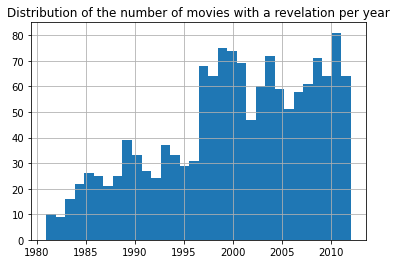

In [18]:
df_movie_revelation['m_release_date'].dt.year.hist(bins=32)
plt.title("Distribution of the number of movies with a revelation per year");

# 2.2 Revelation per pentade

In [19]:
nb_five_years_lower = range(1982, 2008,5)
nb_five_years_upper = range(1987, 2013, 5)

In [20]:
for x , y in zip(nb_five_years_lower, nb_five_years_upper):
    print(x, y)

1982 1987
1987 1992
1992 1997
1997 2002
2002 2007
2007 2012


In [21]:
def define_popularity(min_year, lower_bound, upper_bound):
    if not min_year or min_year >= upper_bound:
        return 'unknown'
    if min_year < lower_bound:
        return 'famous'
    else:
        return 'revelation'

In [22]:
df_chars_revelation = df_movie_revelation.merge(df_chars_merged, on=['wikipedia_m_ID', 'm_release_date'], how='inner').copy()
df_revelations_five_years = dict()
for y_lower, y_upper in zip(nb_five_years_lower, nb_five_years_upper):
    filter_conditions = (
        (df_chars_revelation['m_release_date'].dt.year >= y_lower) & 
        (df_chars_revelation['m_release_date'].dt.year < y_upper)
    )
    columns = ['wikipedia_m_ID', 'm_name', 'm_release_date', 'actor_name', 'is_revealed', 'already_revealed', 'min_year']
    df_filtered = df_chars_revelation.loc[filter_conditions, columns].copy()
    df_filtered['popularity'] = df_filtered['min_year'].apply(lambda x: define_popularity(x, y_lower, y_upper))
    df_revelations_five_years.update({range(y_lower, y_upper): df_filtered.copy()})

In [23]:
df_revelations_five_years[range(1982, 1987)]

,wikipedia_m_ID,m_name,m_release_date,actor_name,is_revealed,already_revealed,min_year,popularity
0,3746,Blade Runner,1982-06-25,William Sanderson,0,0,0,unknown
1,3746,Blade Runner,1982-06-25,Harrison Ford,0,1,1980,famous
2,3746,Blade Runner,1982-06-25,Rutger Hauer,0,0,1985,revelation
3,3746,Blade Runner,1982-06-25,Sean Young,1,0,1982,revelation
4,3746,Blade Runner,1982-06-25,Daryl Hannah,0,0,1984,revelation
...,...,...,...,...,...,...,...,...
18130,29836820,Twilight Theater,1982-01-01,Leslie Nielsen,0,0,1994,unknown
18131,29836820,Twilight Theater,1982-01-01,Rick Moranis,0,0,1986,revelation
18132,29836820,Twilight Theater,1982-01-01,Rosemary Clooney,0,0,0,unknown
18133,29836820,Twilight Theater,1982-01-01,Steve Martin,1,0,1982,revelation


In [47]:
tmp_range = range(1992, 1997)
df_tmp = df_revelations_five_years[tmp_range]

In [36]:
df_tmp = df_tmp.loc[(df_tmp['popularity'] != 'unknown')]

In [48]:
B = nx.Graph()
B.add_nodes_from(df_tmp['actor_name'], bipartite=0)
B.add_nodes_from(df_tmp['wikipedia_m_ID'], bipartite=1)
B.add_weighted_edges_from(
    [(row['wikipedia_m_ID'], row['actor_name'], 1) for idx, row in df_tmp.iterrows()], 
    weight='weight')

In [ ]:
colors = []
for node in B:
    if type(node) == int:
        colors.append("blue")
    else:
        val = df_revelations_five_years[tmp_range][df_revelations_five_years[tmp_range]['actor_name'] == node].values[0][-1]
        if val =='unknown':
            colors.append("gray")
        elif val =='famous':
            colors.append("red")
        else:
            colors.append("yellow")

In [76]:
bb = nx.betweenness_centrality(B_0)

isinstance(bb, dict)

True

In [84]:
sorted_x = sorted(bb.items(), key=lambda kv: kv[1], reverse=True)
sorted_x

[(52389, 0.08143798387514192),
 (171078, 0.07865878668567547),
 (939203, 0.05946838079480302),
 (441315, 0.05839323122574323),
 ('Samuel L. Jackson', 0.057589453299018774),
 (543433, 0.056958356615026864),
 ('Jon Lovitz', 0.05153613070601019),
 (99123, 0.04987074616287631),
 (3039544, 0.04934761141212912),
 (2045991, 0.04689183280089712),
 ('Bill Pullman', 0.046198414670076814),
 ('Tom Sizemore', 0.046007381653767505),
 (554858, 0.04528127631769821),
 (21132353, 0.043759559206526875),
 (1252047, 0.04367956995558494),
 (876872, 0.04356791608153851),
 (436955, 0.04220899573243481),
 (685981, 0.042191392829155835),
 (21180, 0.041977119493118366),
 (675832, 0.04177371329760559),
 (616786, 0.04050374248568276),
 (2043990, 0.03956150184896059),
 (350847, 0.039165887677903057),
 (910628, 0.037422296999322736),
 (577663, 0.0370395713386095),
 ('William H. Macy', 0.036992307980660645),
 (13087370, 0.03664074063944211),
 (1812216, 0.0346547207252095),
 (3084955, 0.03435254027556648),
 (695435, 0

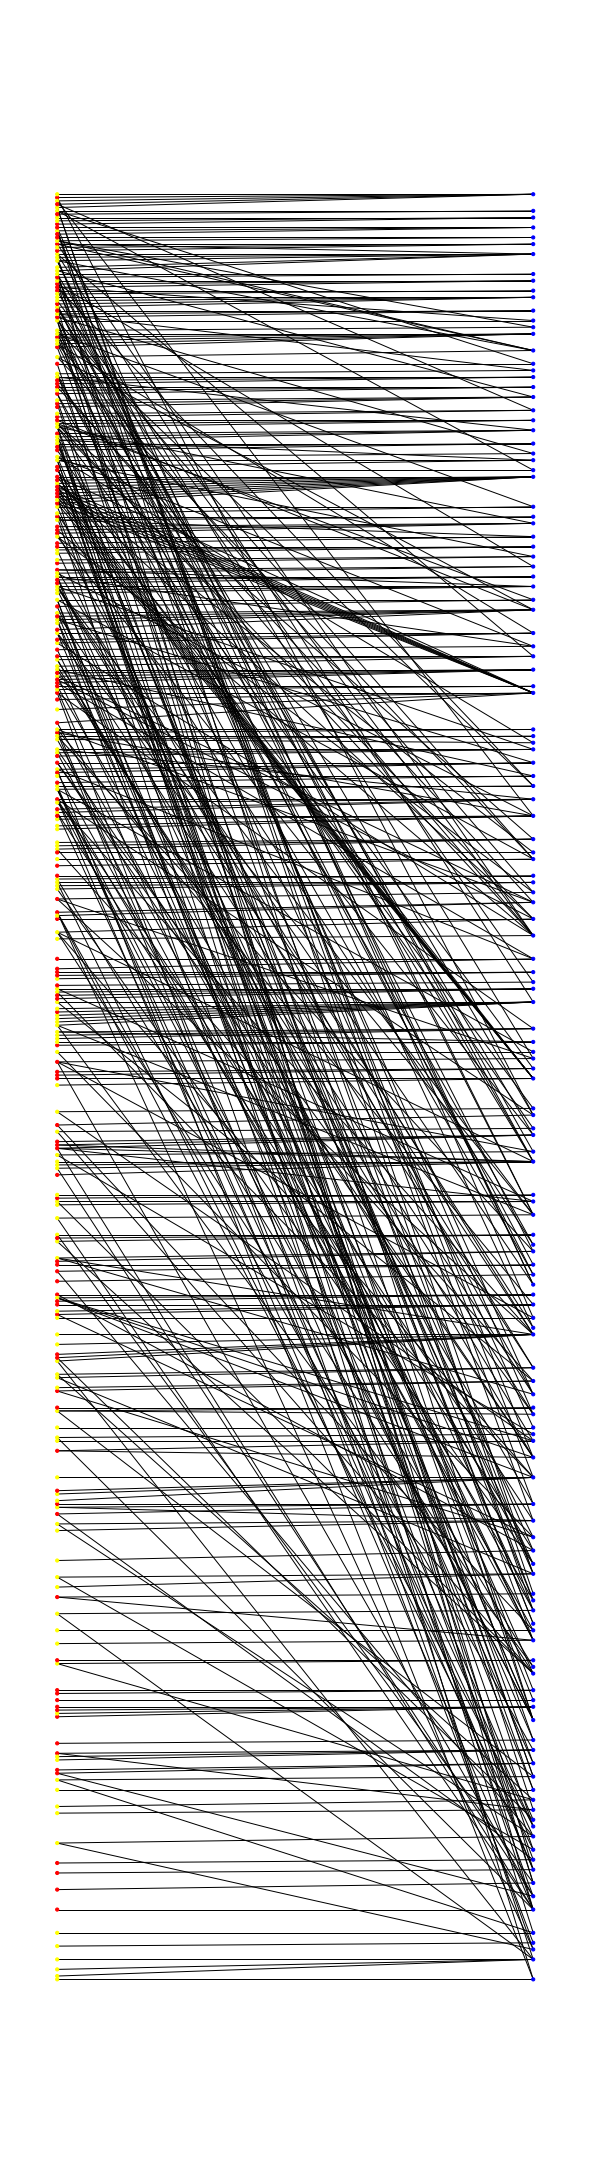

In [41]:
plt.figure(figsize=(8, 30))
pos = {node:[0, i] for i,node in enumerate(df_tmp['actor_name'])}
pos.update({node:[1, i] for i,node in enumerate(df_tmp['wikipedia_m_ID'])})
nx.draw(B, pos, node_color=colors, with_labels=False, node_size=10)
for p in pos:  # raise text positions
    pos[p][1] += 0.1
#nx.draw_networkx_labels(B, pos)

In [70]:
largest_cc = max(nx.connected_components(B), key=len)
S = [B.subgraph(c).copy() for c in nx.connected_components(B)]
B_0 = S[0]

In [72]:
nx.is_connected(B_0)

True

In [110]:
graph = pd.merge(df_revelations_five_years[range(1982, 1987)], df_revelations_five_years[range(1982, 1987)], on=['wikipedia_m_ID', 'm_name', 'm_release_date'])
graph = graph.loc[(graph.popularity_x == 'revelation') & (graph.popularity_y == 'famous')]
graph.head()

,wikipedia_m_ID,m_name,m_release_date,actor_name_x,is_revealed_x,already_revealed_x,min_year_x,popularity_x,actor_name_y,is_revealed_y,already_revealed_y,min_year_y,popularity_y
27,3746,Blade Runner,1982-06-25,Rutger Hauer,0,0,1985,revelation,Harrison Ford,0,1,1980,famous
40,3746,Blade Runner,1982-06-25,Sean Young,1,0,1982,revelation,Harrison Ford,0,1,1980,famous
53,3746,Blade Runner,1982-06-25,Daryl Hannah,0,0,1984,revelation,Harrison Ford,0,1,1980,famous
364,34130,WarGames,1983-06-03,Ally Sheedy,1,0,1983,revelation,Dabney Coleman,0,1,1980,famous
378,34130,WarGames,1983-06-03,Matthew Broderick,0,0,1985,revelation,Dabney Coleman,0,1,1980,famous


In [138]:
graph[graph.duplicated(['actor_name_x', 'actor_name_y'], keep=False)]

,wikipedia_m_ID,m_name,m_release_date,actor_name_x,is_revealed_x,already_revealed_x,min_year_x,popularity_x,actor_name_y,is_revealed_y,already_revealed_y,min_year_y,popularity_y
2018,103088,Dead Men Don't Wear Plaid,1982-05-21,Steve Martin,1,0,1982,revelation,Chevy Chase,0,1,1980,famous
3404,205013,Ghostbusters,1984-06-07,Rick Moranis,0,0,1986,revelation,Bill Murray,0,1,1981,famous
5443,511622,Vacation,1983-07-29,Beverly D'Angelo,1,0,1983,revelation,Chevy Chase,0,1,1980,famous
5503,511622,Vacation,1983-07-29,Anthony Michael Hall,0,0,1984,revelation,Chevy Chase,0,1,1980,famous
5608,511622,Vacation,1983-07-29,John Candy,0,0,1985,revelation,Chevy Chase,0,1,1980,famous
7048,905971,¡Three Amigos!,1986-12-12,Steve Martin,0,1,1982,revelation,Chevy Chase,0,1,1980,famous
8872,1598832,Sesame Street presents Follow That Bird,1985-08-02,John Candy,1,0,1985,revelation,Chevy Chase,0,1,1980,famous
9908,1852179,National Lampoon's European Vacation,1985-07-26,Beverly D'Angelo,0,1,1983,revelation,Chevy Chase,0,1,1980,famous
9974,1852179,National Lampoon's European Vacation,1985-07-26,Anthony Michael Hall,0,1,1984,revelation,Chevy Chase,0,1,1980,famous
11434,3447166,Little Shop of Horrors,1986-12-19,Rick Moranis,1,0,1986,revelation,Bill Murray,0,1,1981,famous


In [112]:
G = nx.from_pandas_edgelist(graph, source='actor_name_x', target='actor_name_y', edge_attr='m_name')

In [114]:
largest_cc = max(nx.connected_components(G), key=len)
S = [G.subgraph(c).copy() for c in nx.connected_components(G)]
G_0 = S[0]
nx.is_connected(G_0)

True

In [126]:
colors = []
for node in G:
    val = df_revelations_five_years[range(1982, 1987)][df_revelations_five_years[range(1982, 1987)]['actor_name'] == node].values[0][-1]
    if val =='revelation':
        colors.append("blue")
    elif val =='famous':
        colors.append("red")


In [130]:
bb_G = nx.betweenness_centrality(G)
sorted_G = sorted(bb_G.items(), key=lambda kv: kv[1], reverse=True)
sorted_G

[('Jeff Goldblum', 0.17100661196505992),
 ('Sigourney Weaver', 0.16561452085069514),
 ('Dennis Quaid', 0.15206898416542247),
 ('Chevy Chase', 0.13564443596839826),
 ('Bill Murray', 0.13051457180880668),
 ('Shelley Duvall', 0.1153816622319184),
 ('William Hurt', 0.10526315789473684),
 ('Rick Moranis', 0.09243818596038592),
 ('Dan Aykroyd', 0.09130633829129815),
 ('Harrison Ford', 0.09076169086237851),
 ('Kurt Russell', 0.09032743597959429),
 ('Barret Oliver', 0.09020338456761372),
 ('Moses Gunn', 0.07964601769911504),
 ('Dustin Hoffman', 0.07386088546438115),
 ('Kate Capshaw', 0.07223099777524644),
 ('Daryl Hannah', 0.06691507529886663),
 ('Steve Martin', 0.06340315728603217),
 ('Griffin Dunne', 0.0538992443222696),
 ('Adrienne King', 0.04807932302492828),
 ('Clint Eastwood', 0.04807932302492828),
 ('Jane Fonda', 0.04807932302492828),
 ('Sissy Spacek', 0.04807932302492828),
 ('Rutger Hauer', 0.04461597564507921),
 ('Dabney Coleman', 0.04362195350492976),
 ('Drew Barrymore', 0.0408321689

In [132]:
bb_G['Robert Hays']

0.0007762769756249029

In [128]:
d = dict(G.degree)

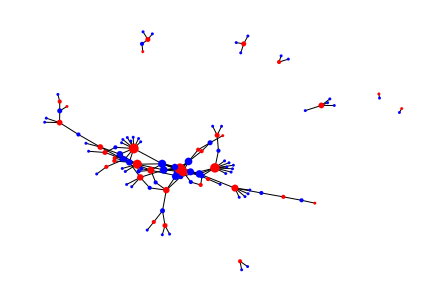

In [129]:
#pos = nx.circular_layout(G)
pos = nx.spring_layout(G)
nx.draw(G, pos=pos, node_size=[v * 8 for v in d.values()], node_color=colors, linewidths=0.1)

In [87]:
graph = pd.merge(df_revelations_five_years[range(1982, 1987)], df_revelations_five_years[range(1982, 1987)], on=['wikipedia_m_ID', 'm_name', 'm_release_date'])
graph = graph[graph.actor_name_x < graph.actor_name_y]
graph.head()

,wikipedia_m_ID,m_name,m_release_date,actor_name_x,is_revealed_x,already_revealed_x,min_year_x,popularity_x,actor_name_y,is_revealed_y,already_revealed_y,min_year_y,popularity_y
13,3746,Blade Runner,1982-06-25,Harrison Ford,0,1,1980,famous,William Sanderson,0,0,0,unknown
15,3746,Blade Runner,1982-06-25,Harrison Ford,0,1,1980,famous,Rutger Hauer,0,0,1985,revelation
16,3746,Blade Runner,1982-06-25,Harrison Ford,0,1,1980,famous,Sean Young,1,0,1982,revelation
18,3746,Blade Runner,1982-06-25,Harrison Ford,0,1,1980,famous,Joanna Cassidy,0,0,1991,unknown
20,3746,Blade Runner,1982-06-25,Harrison Ford,0,1,1980,famous,Morgan Paull,0,0,0,unknown


In [88]:
graph.shape

(9483, 13)

In [90]:
G = nx.from_pandas_edgelist(graph, source='actor_name_x', target='actor_name_y', edge_attr='m_name')

In [93]:
largest_cc = max(nx.connected_components(G), key=len)
S = [G.subgraph(c).copy() for c in nx.connected_components(G)]
G_0 = S[0]
nx.is_connected(G_0)

True

In [94]:
colors = []
for node in G_0:
    val = df_revelations_five_years[range(1982, 1987)][df_revelations_five_years[range(1982, 1987)]['actor_name'] == node].values[0][-1]
    if val =='unknown':
        colors.append("gray")
    elif val =='famous':
        colors.append("red")
    else:
        colors.append("yellow")

In [95]:
d = dict(G.degree)

In [99]:
bb_G = nx.betweenness_centrality(G_0)

In [106]:
df_chars_merged[df_chars_merged['actor_name']=='Michael Winslow']

,wikipedia_m_ID,m_release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,m_name,...,2007,2008,2009,2010,2011,2012,min_year,min_year_score,is_revealed,already_revealed
13001,6043918,1994-08-26,Cadet Larvell Jones,1958-09-06,M,1.816,African Americans,Michael Winslow,35.0,Police Academy: Mission to Moscow,...,133.156146,127.209524,121.774054,116.78624,112.192731,107.948359,1984,570.0,0,1
20516,75222,1987-06-24,Radar Technician,1958-09-06,M,1.816,African Americans,Michael Winslow,28.0,Spaceballs,...,133.156146,127.209524,121.774054,116.78624,112.192731,107.948359,1984,570.0,0,1
23371,24113868,2004-01-01,fficer John Wyndham,1958-09-06,M,1.816,African Americans,Michael Winslow,45.0,Lenny the Wonder Dog,...,133.156146,127.209524,121.774054,116.78624,112.192731,107.948359,1984,570.0,0,1
37868,13779542,2009-01-01,NaN,1958-09-06,M,1.816,African Americans,Michael Winslow,50.0,Bloody 27,...,133.156146,127.209524,121.774054,116.78624,112.192731,107.948359,1984,570.0,0,1
41166,16766524,2008-01-01,Dr. Murphy,1958-09-06,M,1.816,African Americans,Michael Winslow,49.0,RoboDoc,...,133.156146,127.209524,121.774054,116.78624,112.192731,107.948359,1984,570.0,0,1
43155,6043780,1984-03-23,Cadet Larvell Jones,1958-09-06,M,1.816,African Americans,Michael Winslow,25.0,Police Academy,...,133.156146,127.209524,121.774054,116.78624,112.192731,107.948359,1984,570.0,1,0
60972,4485641,1987-04-03,Cadet Larvell Jones,1958-09-06,M,1.816,African Americans,Michael Winslow,28.0,Police Academy 4: Citizens on Patrol,...,133.156146,127.209524,121.774054,116.78624,112.192731,107.948359,1984,570.0,0,1
62063,2102931,1981-06-05,Superman Nut,1958-09-06,M,1.816,African Americans,Michael Winslow,22.0,Nice Dreams,...,133.156146,127.209524,121.774054,116.78624,112.192731,107.948359,1984,570.0,0,0
68751,7272571,1999-05-11,Lee Davis,1958-09-06,M,1.816,African Americans,Michael Winslow,40.0,Lycanthrope,...,133.156146,127.209524,121.774054,116.78624,112.192731,107.948359,1984,570.0,0,1
69882,382387,1984-06-08,Mogwai,1958-09-06,M,1.816,African Americans,Michael Winslow,25.0,Gremlins,...,133.156146,127.209524,121.774054,116.78624,112.192731,107.948359,1984,570.0,1,0


In [100]:
sorted_G = sorted(bb_G.items(), key=lambda kv: kv[1], reverse=True)
sorted_G

[('Robert Hays', 0.08640744433366566),
 ('Jeff Goldblum', 0.06741096151311185),
 ('Jamie Lee Curtis', 0.05778700768927391),
 ('Michael Winslow', 0.054565068027285564),
 ('Martin Balsam', 0.05218315193040392),
 ('M. Emmet Walsh', 0.04801081007584559),
 ('Chevy Chase', 0.04723317013030318),
 ('Rutger Hauer', 0.04671265456026718),
 ('Alan Arkin', 0.044240556339240004),
 ('John Candy', 0.042143400911605844),
 ('Belinda Balaski', 0.041771137376756175),
 ('Sigourney Weaver', 0.04065241507805923),
 ('Charles Durning', 0.039607828269854484),
 ('Brian Dennehy', 0.0339362231922349),
 ('John Cusack', 0.03295025422469572),
 ('Howard Hesseman', 0.031454516631006554),
 ('George Gaynes', 0.031281096187228484),
 ('Barret Oliver', 0.03033408290416884),
 ('William Shatner', 0.028979727484214023),
 ('Harry Dean Stanton', 0.028750035362899627),
 ('Dennis Quaid', 0.028575272997934033),
 ('Max Von Sydow', 0.028408809791257185),
 ('Ed Harris', 0.028018722460543374),
 ('Anthony Michael Hall', 0.02744314451954

ValueError: s must be a scalar, or float array-like with the same size as x and y

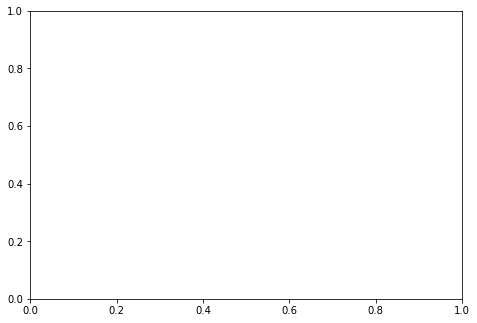

In [97]:
#pos = nx.circular_layout(G)
pos = nx.spring_layout(G_0)
nx.draw(G_0, pos=pos, node_size=[v * 8 for v in d.values()], node_color=colors, linewidths=0.1)

In [86]:
d

{'Harrison Ford': 24,
 'William Sanderson': 21,
 'Rutger Hauer': 109,
 'Sean Young': 23,
 'Joanna Cassidy': 34,
 'Morgan Paull': 12,
 'Joe Turkel': 12,
 'James Hong': 12,
 'M. Emmet Walsh': 47,
 'Hy Pyke': 12,
 'Daryl Hannah': 34,
 'Edward James Olmos': 12,
 'Brion James': 38,
 'Emilio Estevez': 31,
 'Judd Nelson': 14,
 'Molly Ringwald': 33,
 'Paul Gleason': 6,
 'John Kapelos': 22,
 'Anthony Michael Hall': 53,
 'Ally Sheedy': 41,
 'Arnold Schwarzenegger': 11,
 'Michael Biehn': 11,
 'Linda Hamilton': 18,
 'Bill Paxton': 22,
 'Lance Henriksen': 31,
 'Paul Winfield': 11,
 'Franco Columbu': 11,
 'Earl Boen': 11,
 'Dick Miller': 44,
 'Rick Rossovich': 25,
 'Brian Thompson': 11,
 'Bess Motta': 11,
 'Matthew Broderick': 33,
 'Dabney Coleman': 37,
 'John Wood': 17,
 'Barry Corbin': 19,
 'Juanin Clay': 13,
 'Kent Williams': 13,
 'Joe Dorsey': 13,
 'Dennis Lipscomb': 13,
 'James Tolkan': 27,
 'Michael Madsen': 13,
 'Eddie Deezen': 13,
 'Maury Chaykin': 13,
 'Michael Ensign': 28,
 'Dustin Hoffman

In [ ]:
df_revelations_five_years[range(1982, 1986)].sample(22)

In [ ]:
df_chars_revelation = df_chars_merged.merge(df_movie_revelation, on='wikipedia_m_ID', how='left').copy().sort_values(['wikipedia_m_ID', 'is_revealed'], ascending=False)

In [ ]:
df_revelation = df_chars_revelation.drop_duplicates(subset=['wikipedia_m_ID', 'has_revelation'], keep='first')

In [ ]:
df_revelation = df_revelation[df_revelation['score_nb_famous_actors'] > 0].copy()

In [ ]:
df_revelation.groupby('has_revelation').mean()

# 3.5 Number of movies per pentade

In [ ]:
list_years_nb_movies = dict()
for dec_lower, dec_upper in zip(nb_decades_lower, nb_decades_upper):
    filter_conditions = (
        (map_nb_movies_per_year['m_release_year'] >= dec_lower)&
        (map_nb_movies_per_year['m_release_year'] < dec_upper)
    )
    list_dec = map_nb_movies_per_year.loc[filter_conditions]
    list_dec = list_dec.groupby('actor_name')['wikipedia_m_ID'].count().reset_index()
    list_dec['wikipedia_m_ID'] =list_dec['wikipedia_m_ID'].astype(int)
    list_dec.rename({'wikipedia_m_ID': 'nb_movies_dec_{}_{}'.format(dec_lower, dec_upper)}, axis=1, inplace=True)
    list_decades.update({range(dec_lower, dec_upper): list_dec})

In [ ]:
for key, dec in list_decades.items():
    df_chars_numbers = df_chars_numbers.merge(dec, on='actor_name', how='left')
    df_chars_numbers['nb_movies_dec_{}_{}'.format(key.start, key.stop)].fillna(0, inplace=True)

In [ ]:
df_chars_numbers.head(2)

# 3.5 Compute scores per actor at movie time

In [ ]:
df_chars_numbers = df_chars_numbers[df_chars_numbers['m_release_date'].dt.year > 1980].copy()

In [ ]:
nb_unique_movies = df_chars_numbers['wikipedia_m_ID'].nunique()
print("There are {} unique movies with coacting.".format(nb_unique_movies))

In [ ]:
def get_movie_actor_score(row):
    release_date = row['m_release_date'].year
    val = row[str(release_date-1)]
    if val > 0:
        return val
    else:
        return 0

In [ ]:
df_chars_numbers['actor_score'] = df_chars_numbers.apply(lambda row: get_movie_actor_score(row), axis=1)

In [ ]:
sns.scatterplot(data = df_chars_numbers[df_chars_numbers['actor_score']>0], y='nb_years_acting', x='actor_score');

In [ ]:
sns.scatterplot(data = df_chars_numbers.loc[(df_chars_numbers['actor_score']>0)].sort_values('actor_score').drop_duplicates('actor_name', keep='last'), y='nb_years_acting', x='actor_score', hue="actor_gender");

In [ ]:
women_nb_movies_highest_score = df_chars_numbers.loc[(df_chars_numbers['actor_score']>0) & (df_chars_numbers['actor_gender']=='F')].sort_values('actor_score').drop_duplicates('actor_name', keep='last')['nb_years_acting']
men_nb_movies_highest_score = df_chars_numbers.loc[(df_chars_numbers['actor_score']>0) & (df_chars_numbers['actor_gender']=='M')].sort_values('actor_score').drop_duplicates('actor_name', keep='last')['nb_years_acting']

In [ ]:
women_mean_nb_movies_highest_score = women_nb_movies_highest_score.mean()
men_mean_nb_movies_highest_score = men_nb_movies_highest_score.mean()
print("At the peak of their carreer, women had before performed {:.2f} movies in average.".format(women_mean_nb_movies_highest_score))
print("At the peak of their carreer, men had before performed {:.2f} movies in average.".format(men_mean_nb_movies_highest_score))
ttest_ind(women_nb_movies_highest_score, men_nb_movies_highest_score)

In [ ]:
women_highest_score = df_chars_numbers.loc[(df_chars_numbers['actor_score']>0) & (df_chars_numbers['actor_gender']=='F')].sort_values('actor_score').drop_duplicates('actor_name', keep='last')['actor_score']
men_highest_score = df_chars_numbers.loc[(df_chars_numbers['actor_score']>0) & (df_chars_numbers['actor_gender']=='M')].sort_values('actor_score').drop_duplicates('actor_name', keep='last')['actor_score']

In [ ]:
women_mean_highest_score = women_highest_score.mean()
men_mean_highest_score = men_highest_score.mean()
print("At the peak of their carreer, women have in average reached a score of {:.2f}.".format(women_mean_highest_score))
print("At the peak of their carreer, men have in average reached a score of {:.2f}.".format(men_mean_highest_score))
ttest_ind(women_highest_score, men_highest_score)

# 3.6 Compute scores per movie

In [ ]:
nb_unique_actors = df_chars_numbers['actor_name'].nunique()
print("There are {} unique actors with coacting.".format(nb_unique_actors))

In [ ]:
df_chars_numbers.head(2)

In [ ]:
columns = ['wikipedia_m_ID', 'actor_name', 'actor_gender', 'actor_score']
df_temp = df_chars_numbers.copy()
df_temp['actor_score'] = df_temp['actor_score'].astype(str)
df_temp['actor_gender'] = df_temp['actor_gender'].astype(str)
df_grouped = df_temp[columns].groupby('wikipedia_m_ID').agg({'actor_name':'$l$'.join,'actor_gender':'$l$'.join, 'actor_score':'$l$'.join})

In [ ]:
df_grouped

In [ ]:
def get_function_of_list_values(list_values, function, gender=None):
    list_split = list_values.split('$l$')
    list_split = [float(x) for x in list_split]
    if function == 'max':
        return max(list_split)
    if function == 'min':
        return min(list_split)
    if function == 'mean':
        return np.mean(list_split)
    if function == 'median':
        return np.median(list_split)
    if function == 'nb_famous_actors' or function == 'nb_actors_already_played':
        return np.count_nonzero(list_split)
    if function == 'prop_famous_actors' or function == 'prop_nb_movies':
        return (np.count_nonzero(list_split))/float(len(list_split))

In [ ]:
def get_function_of_list_values_condition(row, function, gender_cat=None):
    list_temp = row['actor_score'].split('$l$')
    gender_split = row['actor_gender'].split('$l$')
    list_temp = [float(x) for x in list_temp]
    list_split = []
    for x, gender in zip(list_temp, gender_split):
        if gender == gender_cat:
            list_split.append(x)
    if len(list_split) == 0:
        return np.nan
    if function == 'max':
        return max(list_split)
    if function == 'min':
        return min(list_split)
    if function == 'mean':
        return np.mean(list_split)
    if function == 'median':
        return np.median(list_split)
    if function == 'nb_famous_actors' or function == 'nb_actors_already_played':
        return np.count_nonzero(list_split)
    if function == 'prop_famous_actors' or function == 'prop_nb_movies':
        try:
            return (np.count_nonzero(list_split))/np.count_nonzero(list_temp)
        except:
            return 0

In [ ]:
list_function_score = ['max', 'min', 'mean', 'median', 'nb_famous_actors', 'prop_famous_actors']
for f in list_function_score:
    df_grouped['score_'+f] = df_grouped['actor_score'].apply(lambda x: get_function_of_list_values(x, f))

In [ ]:
list_function_score = ['max', 'min', 'mean', 'median', 'nb_famous_actors', 'prop_famous_actors']
gender_list = ['M', 'F']
for gender in gender_list:
    for f in list_function_score:
        df_grouped[gender+'_'+f] = df_grouped.apply(lambda row: get_function_of_list_values_condition(row, f, gender), axis=1)


In [ ]:
df_grouped['score_prop_famous_actors'].hist()

# 3.7 Merge score with actors

In [ ]:
list_columns = ['score_'+x for x in list_function_score] + ['F_'+x for x in list_function_score] + ['M_'+x for x in list_function_score]

In [ ]:
df_chars_merged = df_chars_numbers.merge(df_grouped[list_columns], left_on='wikipedia_m_ID', right_index=True, how='left').copy()
df_chars_merged.head(3)

# 3.8 Number of actors revealed per movie

# 4.1 Movies that have a revelation

In [ ]:
sns.boxplot(data=df_revelation, x='has_revelation',y='score_prop_famous_actors')

In [ ]:
df_revelation.groupby('has_revelation')['M_prop_famous_actors'].mean()

In [ ]:
df_revelation.groupby('has_revelation')['F_prop_famous_actors'].mean()

In [ ]:
sns.boxplot(data=df_revelation, x='has_revelation',y='M_prop_famous_actors')

In [ ]:
sns.boxplot(data=df_revelation, x='has_revelation',y='F_prop_famous_actors')

In [ ]:
list_columns

In [ ]:
columns = list_columns+['wikipedia_m_ID', 'actor_name', 'has_revelation']
dataset = df_revelation[columns].groupby(['wikipedia_m_ID', 'actor_name']).mean().fillna(0)

# Heatmap of the correlation between the attributes
corr = dataset.corr()
mask = np.triu(np.ones_like(corr, dtype='bool'))

plt.figure(figsize=(15, 8))
cmap = sns.diverging_palette(240,240, as_cmap=True)
sns.heatmap(data=corr, cmap=cmap, center=0, mask=mask, annot=True)
plt.show()

In [ ]:
X = dataset.drop('has_revelation', axis=1)
y = dataset['has_revelation']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Dictionary to store the results
logistic_regression_results = dict()

# Build and fit classifier to training data
clf = LogisticRegression(max_iter=10000, C=0.5, class_weight='balanced')
clf.fit(X_train, y_train)

# Training set accuracy
y_pred = clf.predict(X_train)
acc_tr = accuracy_score(y_pred, y_train) * 100
print("Accuracy on the training data: {:.2f}%".format(acc_tr))

In [ ]:
# Predict the binary output with a cross validationn
y_pred = cross_val_predict(clf, X_test, y_test, cv=10, method="predict")
# Compute the False Positive Rate and True Positive Rate
print(classification_report(y_pred, y_test))

In [ ]:
# Creation of confusion matrix
cm = confusion_matrix(y_test, y_pred)
conf_matrix=pd.DataFrame(data=cm, columns=['Predicted: 0', 'Predicted: 1'], index=['Actual: 0', 'Actual: 1'])
logistic_regression_results.update({'cm': conf_matrix})

# Plot confusion matrix
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap = 'Reds')
plt.title("Confusion matrix")
plt.show()

In [ ]:
# Predict the probabilities with a cross validationn
y_pred = cross_val_predict(clf, X_test, y_test, cv=10, method="predict_proba")

#Compute the precision and recall
precision, recall, _ = precision_recall_curve(y_test, y_pred[:, 1])

#Compute the false positive rate and true positive rate
fpr, tpr, _ = roc_curve(y_test, y_pred[:, 1])

# Compute the area under the P-R curve and ROC curve
pr_score = auc(recall, precision)
roc_score = auc(fpr, tpr)

# Plot P-R curve and ROC curve
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

ax = axs[0]
ax.plot(recall, precision, label='logistic')
ax.plot([1, 0], [0, 1],'r--', label = 'no skill')
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_title("Precision-Recall Curve - Area = {:.3f}".format(pr_score))
ax.legend(loc = 'lower left')

ax = axs[1]
ax.plot(fpr, tpr, label='logistic')
ax.plot([0, 1], [0, 1],'r--', label = 'no skill')
ax.set_xlabel("False positive rate")
ax.set_ylabel("True positive rate")
ax.set_title("ROC Curve - Area = {:.3f}".format(roc_score))
ax.legend(loc = 'lower right')

fig.suptitle('Logistic regression')
fig.tight_layout()
plt.show()

In [ ]:
# Weight of each column in logistic regression
tmp = []
for name, value in zip(dataset.columns, clf.coef_[0]):
    tmp.append({"name": name, "value": value})
    
features_coef = pd.DataFrame(tmp).sort_values("value")

plt.subplots(figsize=(5,7))
plt.barh(features_coef.name, features_coef.value, alpha=0.6)
plt.show()

# 5.1 Carreer booster

In [ ]:
df_movie_revelation = df_chars_revelation[df_chars_revelation['has_revelation'] > 0].copy()
df_movie_revelation.head()

In [ ]:
df_chars_already_revealed = df_movie_revelation[df_movie_revelation['already_revealed'] == 1].copy()
df_chars_already_revealed.head()

In [ ]:
df_tmp = df_chars_already_revealed.groupby('actor_name')['already_revealed'].sum().reset_index().sort_values('already_revealed', ascending=False).copy()
df_tmp.rename({'already_revealed':'nb_movies_when_revelation'}, axis=1, inplace=True)

In [ ]:
df_nb_movies_carreer_booster = df_chars_revelation[df_chars_revelation['already_revealed'] == 1].groupby('actor_name')['wikipedia_m_ID'].count().reset_index().sort_values('wikipedia_m_ID', ascending=False).copy()
df_nb_movies_carreer_booster.rename({'wikipedia_m_ID': 'nb_movies'}, axis=1, inplace=True)

In [ ]:
df_carreer_booster = df_nb_movies_carreer_booster.merge(df_tmp, on='actor_name', how='left').copy()
df_carreer_booster['nb_movies_when_revelation'] = df_carreer_booster['nb_movies_when_revelation'].fillna(0)
df_carreer_booster['ratio_movies_when_revelation'] = df_carreer_booster.apply(lambda row: row['nb_movies_when_revelation']*row['nb_movies_when_revelation'] / row['nb_movies'], axis=1)

In [ ]:
df_carreer_booster.sort_values(['nb_movies_when_revelation', 'ratio_movies_when_revelation'], ascending=False).head(22)

# 6.1 Stay in the loop

In [ ]:
df_numbers_yearly.head(2)

In [ ]:
columns = df_numbers_yearly.columns[1:]

In [ ]:
df_loop = df_chars_merged.loc[(df_chars_merged['already_revealed']==1) & (df_chars_merged['nb_years_acting']>=1)].sort_values(['actor_name', 'm_release_date']).drop_duplicates(['actor_name'], keep='first').copy()
df_loop.drop(columns, axis=1, inplace=True)
df_loop = df_loop.merge(df_numbers_yearly, on='actor_name', how='left').copy()
df_loop.dropna(subset=['actor_gender'], inplace=True)
df_loop.head()

In [ ]:
df_loop['actor_gender'].value_counts()

In [ ]:
def get_score_year(row):
    release_year = row['m_release_date'].year
    return int(row['{}'.format(release_year)] > 0)

In [ ]:
df_loop['still_ranked'] = df_loop.apply(lambda row: get_score_year(row), axis=1)

In [ ]:
df_loop['is_main_actor'] = (df_loop['score_max'] == df_loop['min_year_score']).astype(int)

In [ ]:
df_loop['is_main_actor'].sum()

In [ ]:
df_loop['still_ranked'].sum()

In [ ]:
df_loop[df_loop['still_ranked'] == 1]['is_main_actor'].sum()

In [ ]:
df_loop.loc[(df_loop['is_main_actor'] == 0) & (df_loop['still_ranked'] == 0)].shape

In [ ]:
df_loop.loc[(df_loop['is_main_actor'] == 1) & (df_loop['still_ranked'] == 0)].shape

In [ ]:
df_loop.loc[(df_loop['is_main_actor'] == 1) & (df_loop['still_ranked'] == 1)].shape

In [ ]:
df_loop.loc[(df_loop['is_main_actor'] == 0) & (df_loop['still_ranked'] == 1)].shape

In [ ]:
#df_loop.drop_duplicates('wikipedia_m_ID', keep='first', inplace=True)

In [ ]:
df_loop['wikipedia_m_ID'].nunique()

In [ ]:
df_loop.groupby('still_ranked')[list_columns+['is_main_actor']].mean()

In [ ]:
df_loop[df_loop['actor_gender']=='M'].groupby('still_ranked')[list_columns+['is_main_actor']].mean()

In [ ]:
df_loop[df_loop['actor_gender']=='F'].groupby('still_ranked')[list_columns+['is_main_actor']].mean()

In [ ]:
sns.histplot(data=df_loop,x='actor_gender',hue='still_ranked', cumulative=False, multiple='fill', stat='proportion')
plt.grid();

In [ ]:
sns.boxplot(data=df_loop,x='actor_gender',y='score_max', hue='still_ranked')

In [ ]:
sns.boxplot(data=df_loop,x='actor_gender',y='F_max', hue='still_ranked')

In [ ]:
sns.boxplot(data=df_loop,x='actor_gender',y='M_max', hue='still_ranked')

In [ ]:
df_tmp = df_loop.dropna()
ttest_ind(df_tmp[df_tmp['still_ranked']==1]['M_max'], df_tmp[df_tmp['still_ranked']==0]['M_max'])

In [ ]:
ttest_ind(df_tmp[df_tmp['still_ranked']==1]['F_max'], df_tmp[df_tmp['still_ranked']==0]['F_max'])

# 6.2 Correlation

In [ ]:
columns = list_columns+['wikipedia_m_ID', 'actor_name', 'still_ranked']
dataset = df_loop[columns].groupby(['wikipedia_m_ID', 'actor_name']).mean().fillna(0)

# Heatmap of the correlation between the attributes
corr = dataset.corr()
mask = np.triu(np.ones_like(corr, dtype='bool'))

plt.figure(figsize=(15, 8))
cmap = sns.diverging_palette(240,240, as_cmap=True)
sns.heatmap(data=corr, cmap=cmap, center=0, mask=mask, annot=True)
plt.show()

In [ ]:
X = dataset.drop('still_ranked', axis=1)
y = dataset['still_ranked']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Dictionary to store the results
logistic_regression_results = dict()

# Build and fit classifier to training data
clf = LogisticRegression(solver='lbfgs', max_iter=10000,penalty='l2', C=0.2, class_weight='balanced')
clf.fit(X_train, y_train)

# Training set accuracy
y_pred = clf.predict(X_train)
acc_tr = accuracy_score(y_pred, y_train) * 100
print("Accuracy on the training data: {:.2f}%".format(acc_tr))

In [ ]:
# Predict the binary output with a cross validationn
y_pred = cross_val_predict(clf, X_test, y_test, cv=10, method="predict")
# Compute the False Positive Rate and True Positive Rate
print(classification_report(y_pred, y_test))

In [ ]:
# Creation of confusion matrix
cm = confusion_matrix(y_test, y_pred)
conf_matrix=pd.DataFrame(data=cm, columns=['Predicted: 0', 'Predicted: 1'], index=['Actual: 0', 'Actual: 1'])
logistic_regression_results.update({'cm': conf_matrix})

# Plot confusion matrix
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap = 'Reds')
plt.title("Confusion matrix")
plt.show()

In [ ]:
# Predict the probabilities with a cross validationn
y_pred = cross_val_predict(clf, X_test, y_test, cv=10, method="predict_proba")

#Compute the precision and recall
precision, recall, _ = precision_recall_curve(y_test, y_pred[:, 1])

#Compute the false positive rate and true positive rate
fpr, tpr, _ = roc_curve(y_test, y_pred[:, 1])

# Compute the area under the P-R curve and ROC curve
pr_score = auc(recall, precision)
roc_score = auc(fpr, tpr)

# Plot P-R curve and ROC curve
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

ax = axs[0]
ax.plot(recall, precision, label='logistic')
ax.plot([1, 0], [0, 1],'r--', label = 'no skill')
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_title("Precision-Recall Curve - Area = {:.3f}".format(pr_score))
ax.legend(loc = 'lower left')

ax = axs[1]
ax.plot(fpr, tpr, label='logistic')
ax.plot([0, 1], [0, 1],'r--', label = 'no skill')
ax.set_xlabel("False positive rate")
ax.set_ylabel("True positive rate")
ax.set_title("ROC Curve - Area = {:.3f}".format(roc_score))
ax.legend(loc = 'lower right')

fig.suptitle('Logistic regression')
fig.tight_layout()
plt.show()

In [ ]:
# Weight of each column in logistic regression
tmp = []
for name, value in zip(dataset.columns, clf.coef_[0]):
    tmp.append({"name": name, "value": value})
    
features_coef = pd.DataFrame(tmp).sort_values("value")

plt.subplots(figsize=(5,7))
plt.barh(features_coef.name, features_coef.value, alpha=0.6)
plt.show()

# 7 Analysis by decade

In [ ]:
df_revelation['m_release_dec'] = df_revelation['m_release_date'].apply(lambda x: x.year//10*10)

In [ ]:
df_revelation.groupby(['m_release_dec', 'has_revelation']).mean()

In [ ]:
plt.figure(figsize=(15, 6))
sns.boxplot(data=df_revelation, x='m_release_dec', y='nb_actors')

In [ ]:
plt.figure(figsize=(15, 6))
sns.boxplot(data=df_revelation, x='m_release_dec', y='score_prop_famous_actors', hue='has_revelation')

In [ ]:
df_revelation[df_revelation['m_release_dec'] >= 2010]

In [ ]:
plt.figure(figsize=(15, 6))
sns.histplot(data=df_revelation, x='m_release_dec');

In [ ]:
plt.figure(figsize=(15, 6))
sns.boxplot(data=df_revelation, x='m_release_dec', y='score_mean', hue='has_revelation')

In [ ]:
df_revelation.columns

In [ ]:
for dec in df_revelation['m_release_dec'].sort_values().unique():
    df_tmp = df_revelation[df_revelation['m_release_dec'] == dec]
    

In [ ]:
df_revelation[df_revelation['nb_movies_dec_1990_2000'] >0]

In [ ]:
df_revelation.loc[(df_revelation['m_release_date'].dt.year >= 2010) & (df_revelation['m_release_date'].dt.year < 2020)].groupby('has_revelation').mean()

In [ ]:
df_revelation.loc[(df_revelation['m_release_date'].dt.year >= 2000) & (df_revelation['m_release_date'].dt.year < 2010)].groupby('has_revelation').mean()

In [ ]:
df_revelation.loc[(df_revelation['m_release_date'].dt.year >= 1990) & (df_revelation['m_release_date'].dt.year < 2000)].groupby('has_revelation').mean()

In [ ]:
df_revelation.loc[(df_revelation['m_release_date'].dt.year < 1990)].groupby('has_revelation').mean()